# Notes for "Deep Learning for Portfolio Optimization"

Reference Paper: [Deep Learning for Portfolio Optimization](https://arxiv.org/abs/2005.13665)

---

In [1]:
import omega as o
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

In [69]:
def create_lstm_input(data, lookback_window):
    n_features = data.shape[1]
    n_samples = len(data) - lookback_window
    lstm_input = np.zeros((n_samples, lookback_window, n_features))
    for i in range(n_samples):
        lstm_input[i] = data.iloc[i:i + lookback_window].values
    return lstm_input

def create_lstm_target(data, lookback):
    n_samples = len(data) - lookback
    target_data = data.iloc[lookback:].values[:n_samples]
    return target_data

def objective(outputs, targets):
    portfolio_returns = (outputs * targets).sum(dim=1)
    mean_portfolio_return = portfolio_returns.mean() * 252
    mean_squared_portfolio_return = (portfolio_returns ** 2).mean() * (252 ** 2)
    denominator = torch.sqrt(mean_squared_portfolio_return - mean_portfolio_return ** 2)
    custom_objective_value = mean_portfolio_return / denominator
    return custom_objective_value

In [288]:
start = '2020-01-01'
end = '2023-08-05'

indices = ['VTI', 'AGG', 'DBC', '^VIX']
prices = o.Ticker(indices).bulk_prices(start, end)
returns = np.log(prices).diff()[1:]

features = pd.concat([prices.loc[returns.index], returns], axis=1)
features.head(3)

,VTI,AGG,DBC,^VIX,VTI,AGG,DBC,^VIX
Date,,,,,,,,
2020-01-03,155.198914,104.343880,16.063013,14.02,-0.006385,0.002924,0.011827,0.117159
2020-01-06,155.729111,104.260796,16.092834,13.85,0.003410,-0.000797,0.001855,-0.012200
2020-01-07,155.359894,104.150002,16.082893,13.79,-0.002374,-0.001063,-0.000618,-0.004342


In [197]:
lookback=1

lstm_input  = create_lstm_input(features, lookback)
lstm_target = create_lstm_target(returns, lookback)

In [40]:
class PortfolioOptimizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PortfolioOptimizationNetwork, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_last_time_step = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out_last_time_step)
        output = self.softmax(fc_out)
        return output

input_dim = lstm_input.shape[-1] # number of features
hidden_dim = 50
output_dim = lstm_target.shape[-1] # number of indices

In [158]:
model = PortfolioOptimizationNetwork(input_dim, hidden_dim, output_dim)

train_size = int(0.8 * len(lstm_input))

train_input = lstm_input[:train_size]
train_target = lstm_target[:train_size]

test_input = lstm_input[train_size:]
test_target = lstm_target[train_size:]

train_input_torch = torch.tensor(train_input, dtype=torch.float32)
train_target_torch = torch.tensor(train_target, dtype=torch.float32)

test_input_torch = torch.tensor(test_input, dtype=torch.float32)
test_target_torch = torch.tensor(test_target, dtype=torch.float32)

optimizer = torch.optim.Adam(model.parameters(), maximize=True)
epochs = 100

for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_input_torch)
    gain = objective(outputs, train_target_torch)
    gain.backward()
    optimizer.step()
    print(f'{gain.item()}', end='\r')

In [160]:
lstm_target

array([[ 0.04892446, -0.02619072, -0.01594374, -0.08555023],
       [-0.05935558, -0.03883445, -0.03359366,  0.00708842],
       [ 0.00735488,  0.02208693,  0.02101493, -0.05997077],
       ...,
       [-0.01267038, -0.00174954, -0.01138226,  0.02238046],
       [ 0.0182158 ,  0.0037011 , -0.0012272 , -0.03212754],
       [-0.00255959, -0.00473148,  0.00896499,  0.01067046]])

In [134]:
model.eval()
test_in = torch.tensor(test_input, dtype=torch.float32)
with torch.no_grad():
    outputs = model(test_input_torch)

In [155]:
lstm_input[:train_size]

array([[[ 1.55198959e+02,  1.04343910e+02,  1.60630131e+01, ...,
          2.92452306e-03,  1.18270469e-02,  1.17159133e-01],
        [ 1.55729126e+02,  1.04260788e+02,  1.60928345e+01, ...,
         -7.96935626e-04,  1.85480444e-03, -1.21996541e-02],
        [ 1.55359879e+02,  1.04149994e+02,  1.60828934e+01, ...,
         -1.06322789e-03, -6.17925502e-04, -4.34157114e-03],
        ...,
        [ 1.17954224e+02,  1.02110672e+02,  1.19081001e+01, ...,
         -4.08334411e-02, -4.08887393e-02,  3.36604736e-01],
        [ 1.28690231e+02,  1.03714706e+02,  1.20373201e+01, ...,
          1.55866775e-02,  1.07929835e-02, -2.66227539e-01],
        [ 1.14044189e+02,  1.05448578e+02,  1.13117018e+01, ...,
          1.65794985e-02, -6.21740899e-02,  3.57591001e-01]],

       [[ 1.55729126e+02,  1.04260788e+02,  1.60928345e+01, ...,
         -7.96935626e-04,  1.85480444e-03, -1.21996541e-02],
        [ 1.55359879e+02,  1.04149994e+02,  1.60828934e+01, ...,
         -1.06322789e-03, -6.17925502e

In [132]:
outputs.shape

torch.Size([141, 4])

In [142]:
test_target

array([[-3.01403660e-02, -7.77145507e-03, -9.87503474e-03,
         6.16837352e-02],
       [-4.16902544e-02, -1.65292163e-02, -1.13108280e-02,
         2.03712760e-01],
       [-2.83133773e-03, -5.94136610e-03, -1.11018376e-02,
        -3.98794217e-02],
       [ 1.44468129e-02,  1.10486752e-02,  6.76372351e-04,
        -9.86193416e-02],
       [-3.55319944e-02,  2.39451281e-03,  4.38520741e-03,
         1.06541447e-01],
       [ 3.76287566e-03, -9.96864356e-05, -3.63302541e-02,
        -5.68193266e-02],
       [ 2.39344126e-02, -3.99420836e-03, -2.44627753e-03,
        -3.06611961e-02],
       [-1.59493398e-04,  8.46911582e-03, -1.80057746e-02,
        -4.19405310e-02],
       [ 9.02614502e-03,  4.15835673e-03, -2.26995819e-02,
         3.44822666e-03],
       [ 3.18032832e-02, -1.58197875e-03,  9.43062669e-03,
        -6.46991672e-02],
       [-3.07867753e-03, -4.46336752e-03, -2.16845008e-03,
        -1.03359642e-02],
       [-2.08227995e-02,  3.97420929e-04,  1.18685317e-02,
      

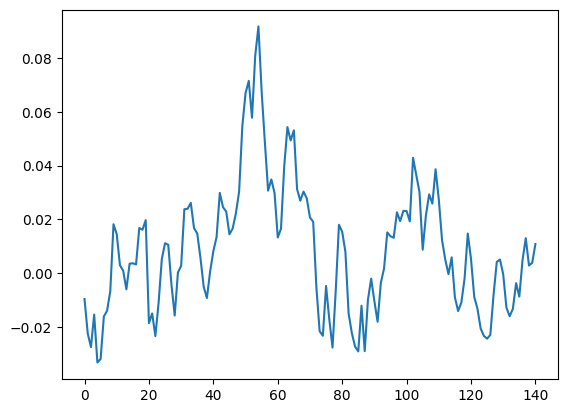

In [136]:
plt.plot((outputs * test_target).sum(dim=1).cumsum(dim=0))

In [289]:
class PortfolioOptimizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PortfolioOptimizationNetwork, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_last_time_step = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out_last_time_step)
        output = self.softmax(fc_out)
        return output

class LSTMPortfolioOptimizer:

    def __init__(self, prices, lookback=50, train_pct=.8, hidden_dim=50):
        self.prices = prices
        self.returns = np.log(self.prices).diff()[1:]
        self.features = pd.concat([self.prices.loc[self.returns.index], self.returns], axis=1)
        self.lookback = lookback
        self.train_pct = train_pct
        self.hidden_dim = hidden_dim
        self._init()

    def train(self, epochs=100):
        self.model = PortfolioOptimizationNetwork(self.input_dim, self.hidden_dim, self.output_dim)
        self.optimizer = torch.optim.Adam(self.model.parameters(), maximize=True)
        for epoch in tqdm(range(epochs)):
            self.model.train()
            self.optimizer.zero_grad()
            outputs = self.model(self.train_input_torch)
            gain = self.objective(outputs, self.train_target_torch)
            gain.backward()
            self.optimizer.step()
            print(f'Epoch {epoch+1}/{epochs}: Gain: {gain.item()}', end='\r')

            self.model.eval()
            with torch.no_grad():
                self.weights = self.model(self.test_input_torch)

            self.test_returns = self.weights * self.test_target
        
    def _init(self):
        self.input = self.create_lstm_input(self.features, self.lookback)
        self.target = self.create_lstm_target(self.returns, self.lookback)
        self.train_size = int(self.train_pct * len(self.input))
        self.train_input = self.input[:self.train_size]
        self.train_target = self.target[:self.train_size]
        self.test_input = self.input[self.train_size:]
        self.test_target = self.target[self.train_size:]
        self.input_dim = self.input.shape[-1]
        self.output_dim = self.target.shape[-1]
        self.train_input_torch = torch.tensor(self.train_input, dtype=torch.float32)
        self.train_target_torch = torch.tensor(self.train_target, dtype=torch.float32)
        self.test_input_torch = torch.tensor(self.test_input, dtype=torch.float32)
        self.test_target_torch = torch.tensor(self.test_target, dtype=torch.float32)

    @staticmethod
    def create_lstm_input(data, lookback_window):
        n_features = data.shape[1]
        n_samples = len(data) - lookback_window
        lstm_input = np.zeros((n_samples, lookback_window, n_features))
        for i in range(n_samples):
            lstm_input[i] = data.iloc[i:i + lookback_window].values
        return lstm_input

    @staticmethod
    def create_lstm_target(data, lookback):
        n_samples = len(data) - lookback
        target_data = data.iloc[lookback:].values[:n_samples]
        return target_data

    @staticmethod
    def objective(outputs, targets):
        portfolio_returns = (outputs * targets).sum(dim=1)
        mean_portfolio_return = portfolio_returns.mean() * 252
        mean_squared_portfolio_return = (portfolio_returns ** 2).mean() * (252 ** 2)
        denominator = torch.sqrt(mean_squared_portfolio_return - mean_portfolio_return ** 2)
        custom_objective_value = mean_portfolio_return / denominator
        return custom_objective_value

In [290]:
po = LSTMPortfolioOptimizer(prices, lookback=50, train_pct=0.8, hidden_dim=50)

In [291]:
po.train(epochs=500)

  0%|          | 0/500 [00:00<?, ?it/s]

<Axes: xlabel='Date'>

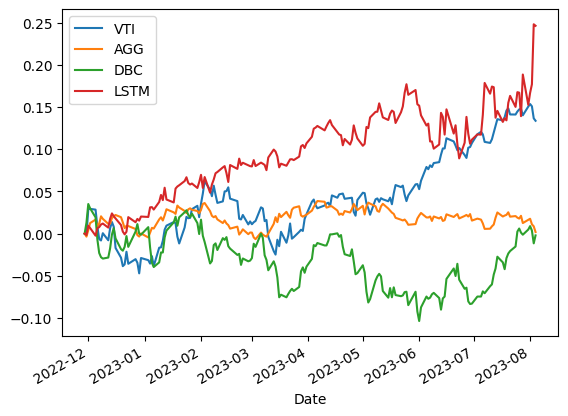

In [294]:
model_returns = pd.DataFrame(po.test_returns).sum(axis=1)
comparison = po.returns[-len(model_returns):].copy()
comparison['LSTM'] = model_returns.values
comparison = comparison.drop(columns='^VIX')
comparison = comparison.shift()
comparison.loc[comparison.index.min()] = 0
comparison.cumsum().plot()

In [295]:
comparison.cumsum()

,VTI,AGG,DBC,LSTM
Date,,,,
2022-11-29,0.000000,0.000000,0.000000,0.000000
2022-11-30,-0.001565,-0.003582,0.012919,-0.001653
2022-12-01,0.028784,0.004180,0.035133,0.009372
2022-12-02,0.029372,0.012467,0.030020,0.006633
2022-12-05,0.028441,0.016605,0.019317,-0.002466
...,...,...,...,...
2023-07-31,0.150857,0.016406,0.004800,0.152911
2023-08-01,0.153883,0.017635,0.008860,0.167100
2023-08-02,0.151164,0.010992,0.003579,0.177341
